In [6]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import spacy
import sklearn as sk
import gensim

Import our topic modeling library `Top2Vec` ([Documentation](https://top2vec.readthedocs.io/en/latest/))

In [7]:
from top2vec import Top2Vec
import openai

The notebook relies on `dir` to locate the directory storing our data, in the form of csv files

In [10]:
dir = '../data'

`Top2Vec` uses language models to project sentences as vector embeddings. It requires no additional preprocessing, tokenization, stemming and lemmatization. The `tokenize` function is used for the calculation of coherence score only

In [11]:
tokenize = lambda d: gensim.utils.simple_preprocess( gensim.parsing.preprocessing.strip_tags( d ), deacc=True )

# load data

In [12]:
train_dfs = [ pd.read_csv( f'{dir}/nlpdata-8606-cleansed.csv', encoding='utf8' ) ]
print( train_dfs[ 0 ].shape )
train_dfs[ 0 ].head()

(8577, 8)


,kewords,Label,Question,Answer,topic,sub-topic,source,qid
0,NaN,NaN,What were the sources of atmospheric nutrients...,The primary sources of atmospheric nutrients t...,NaN,NaN,NaN,0.0
1,NaN,NaN,How was the fertilization effect on phytoplank...,The fertilization effect on phytoplankton was ...,NaN,NaN,NaN,1.0
2,NaN,NaN,How do rising temperatures affect Alpine lakes?,Rising temperatures increase mineral weatherin...,NaN,NaN,NaN,2.0
3,NaN,NaN,How has an increase in phytoplankton biomass b...,Significant increase in phytoplankton biomass ...,NaN,NaN,NaN,3.0
4,NaN,NaN,How do higher metabolic rates of organisms and...,Higher metabolic rates of organisms and longer...,NaN,NaN,NaN,4.0


# preprocess (without lemmatization)

The only steps involved here are to concatenate `Question` and `Answer` and remove footnote numbers

In [13]:
for df in train_dfs:
    df[ 'text' ] = df.Question + ' ' + df.Answer.str.replace( r'\[[0-9]*\]', '' )

In [14]:
train_dfs[ 0 ].head()

,kewords,Label,Question,Answer,topic,sub-topic,source,qid,text
0,NaN,NaN,What were the sources of atmospheric nutrients...,The primary sources of atmospheric nutrients t...,NaN,NaN,NaN,0.0,What were the sources of atmospheric nutrients...
1,NaN,NaN,How was the fertilization effect on phytoplank...,The fertilization effect on phytoplankton was ...,NaN,NaN,NaN,1.0,How was the fertilization effect on phytoplank...
2,NaN,NaN,How do rising temperatures affect Alpine lakes?,Rising temperatures increase mineral weatherin...,NaN,NaN,NaN,2.0,How do rising temperatures affect Alpine lakes...
3,NaN,NaN,How has an increase in phytoplankton biomass b...,Significant increase in phytoplankton biomass ...,NaN,NaN,NaN,3.0,How has an increase in phytoplankton biomass b...
4,NaN,NaN,How do higher metabolic rates of organisms and...,Higher metabolic rates of organisms and longer...,NaN,NaN,NaN,4.0,How do higher metabolic rates of organisms and...


# train topic models

Some of the supported pre-trained language models are listed below.
1. Sentence transformer (`distiluse-base-multilingual-cased` and `all-MiniLM-L6-v2`)
1. Dense averaging network (`universal-sentence-encoder`)
1. Doc2Vec (by default if nothing is specified)

Universal sentence encoder is preferred as it is intentionally trained to compare the similarity between sentences and achieves a good coherence score among the models

In [15]:
def train( df ):
  docs = df.text.to_list()
  # train topc model
  m = Top2Vec(
    docs,
    embedding_model='distiluse-base-multilingual-cased',
    # embedding_model='universal-sentence-encoder',
    # embedding_model='all-MiniLM-L6-v2',
    use_embedding_model_tokenizer=True,
    min_count=1,
    verbose=False,
  )
  return m

In [16]:
def calculate_coherence_score( m, df ):
  docs = df.text.to_list()
  # calculate coherence score
  tokenized_docs = [ tokenize( d ) for d in docs ]
  dictionary = gensim.corpora.Dictionary( tokenized_docs )
  return gensim.models.CoherenceModel(
    topics=[ m.get_topics( i )[ 0 ][ 0 ] for i in range( m.get_num_topics() ) if len( m.get_topics( i )[ 0 ] ) > 0 ],
    corpus=[ dictionary.doc2bow( doc ) for doc in tokenized_docs ],
    dictionary=dictionary,
    texts=tokenized_docs,
    coherence='c_v',
  ).get_coherence()

In [17]:
m = train( train_dfs[ 0 ] )
m.get_num_topics()

2023-04-24 14:21:32,884 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model


77

In [18]:
calculate_coherence_score( m, train_dfs[ 0 ] )

0.7411852564169482

# generate topic names

Topic names are generated based on the top 30 words in the bag of words in each topic. If the topic name are too general, it may be caused by
1. not enough semantic diversity in the 30 words in each topic; or
1. not enough dimensionality in generating document embeddings by UMAP to retain enough semnatic information; or
1. not enough data in term of the number of q&a items in the whole dataset and/or the number of words in each q&a item

In [19]:
topic_words, topic_word_scores, topic_nums = m.get_topics()
print( topic_words.shape )
topic_words[ :, 0 ]

(77, 50)


array(['thermodynamics', 'article', 'research', 'statistical',
       'coefficients', 'research', 'fisheries', 'model', 'meteorology',
       'temperature', 'optimization', 'deforestation', 'paperempower',
       'decarbonization', 'vegetation', 'energy', 'climatological',
       'simulation', 'ecotypes', 'costs', 'researching', 'coal',
       'energyplan', 'goal', 'thermodynamics', 'percentage', 'soil',
       'modular', 'electric', 'changes', 'metric', 'airwater', 'solar',
       'renewables', 'efficiencies', 'flood', 'decarbonization',
       'influencing', 'energyplus', 'data', 'climatological', 'wind',
       'photovoltaic', 'fuel', 'buildings', 'respondents', 'pump',
       'thermodynamics', 'thermodynamics', 'demand', 'aquaculture',
       'demand', 'photovoltaic', 'climatological', 'buildings', 'funding',
       'oxidation', 'norwegian', 'irradiation', 'snow', 'rainfall',
       'recycling', 'where', 'correlation', 'houses', 'grasslands',
       'simulation', 'mongolia', 'digit

In [22]:
openai.organization = 'the-organization-id'
openai.api_key = 'a-valid-key'

In [21]:
def generate_topic_name( words ):
  p = 'generate a topic name with no more than 3 words for the following words: ' + ', '.join( words )
  response = openai.Completion.create(
    model="text-davinci-003",
    prompt=p,
    temperature=0.9,
    max_tokens=150,
    top_p=1,
    frequency_penalty=1,
    presence_penalty=1
  )
  return response.choices[0].text.split('\n')[-1].strip()

In [22]:
topic_names = { num: generate_topic_name( words ) for [ words, num ] in zip( topic_words[ :, : 30 ], topic_nums ) }

In [23]:
train_dfs[ 0 ][ 'topic_words' ] = [ ', '.join( words ) for words in m.get_documents_topics( train_dfs[ 0 ].index.tolist() )[ 2 ] ]

In [24]:
train_dfs[ 0 ][ 'topic_name' ] = [ topic_names[ topic_num ] for topic_num in m.get_documents_topics( train_dfs[ 0 ].index.tolist() )[ 0 ] ]

In [ ]:
train_dfs[ 0 ][ [ 'Question', 'Answer', 'topic_name', 'topic_words' ] ].to_csv(
    '8606-subtopics.csv',
    index=False,
)

# visualization

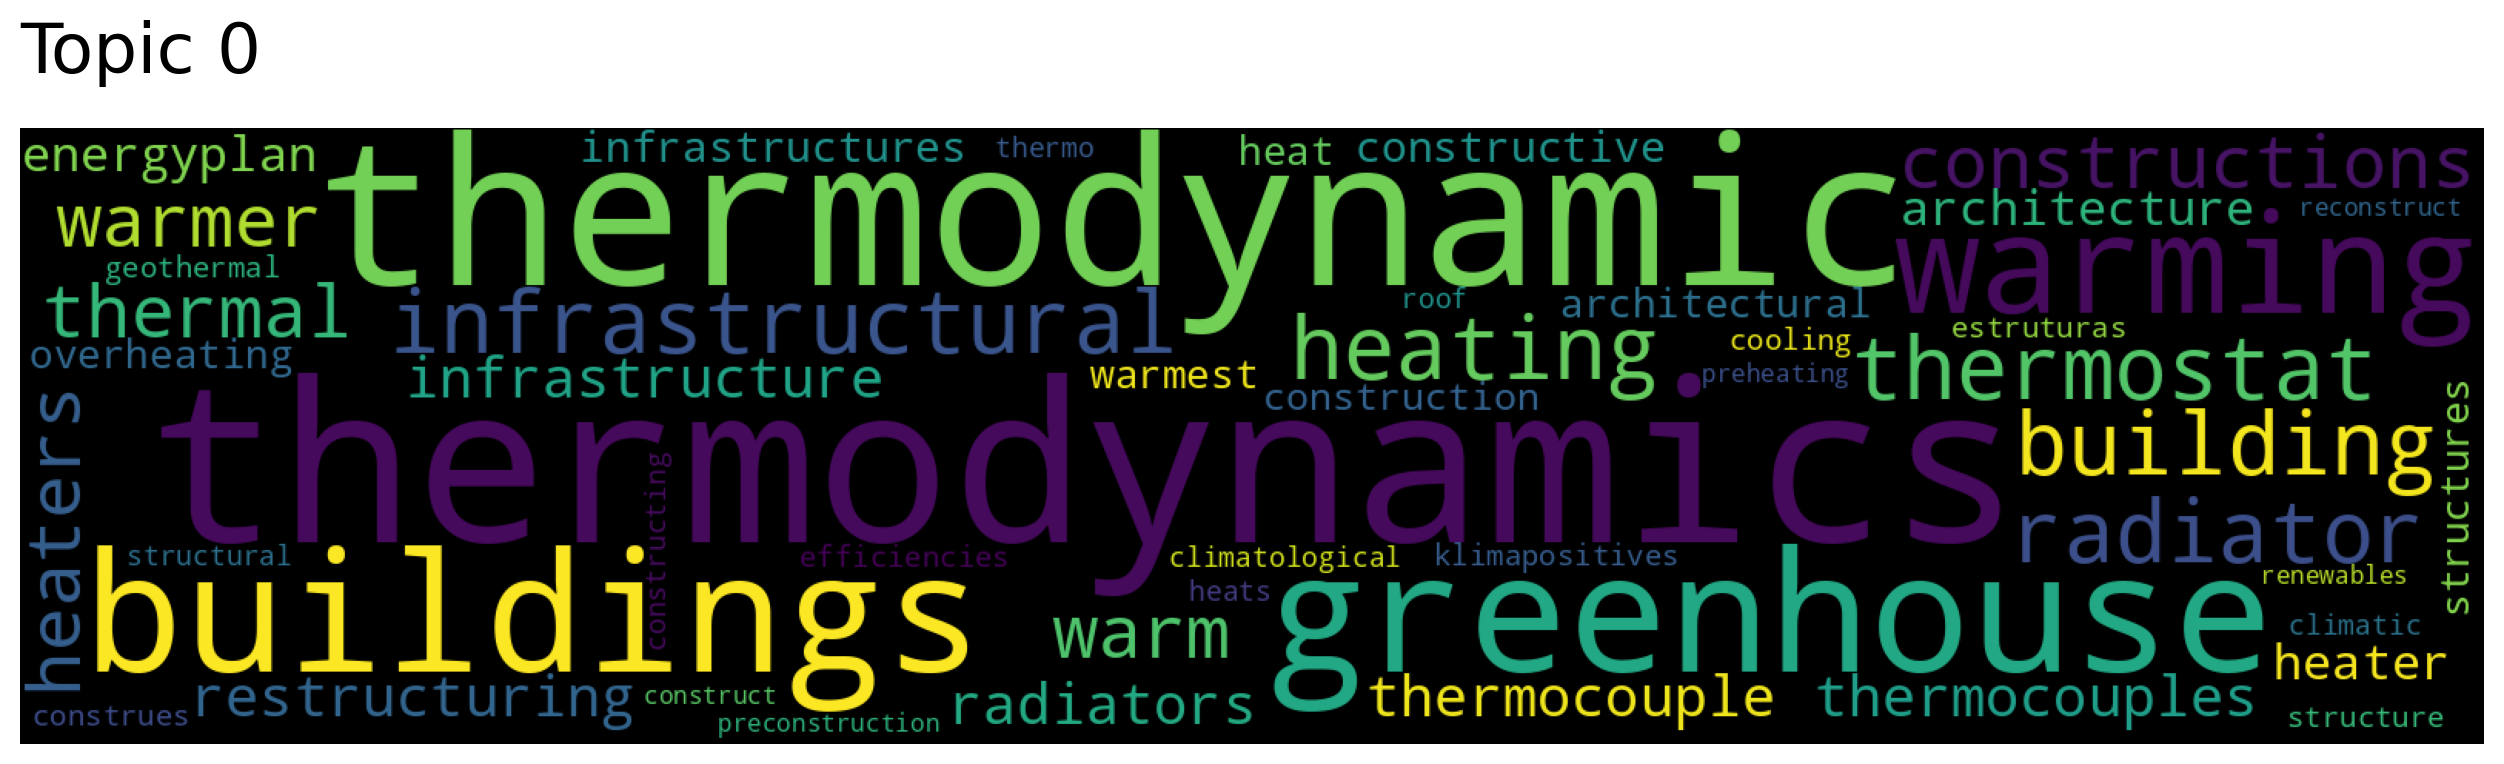

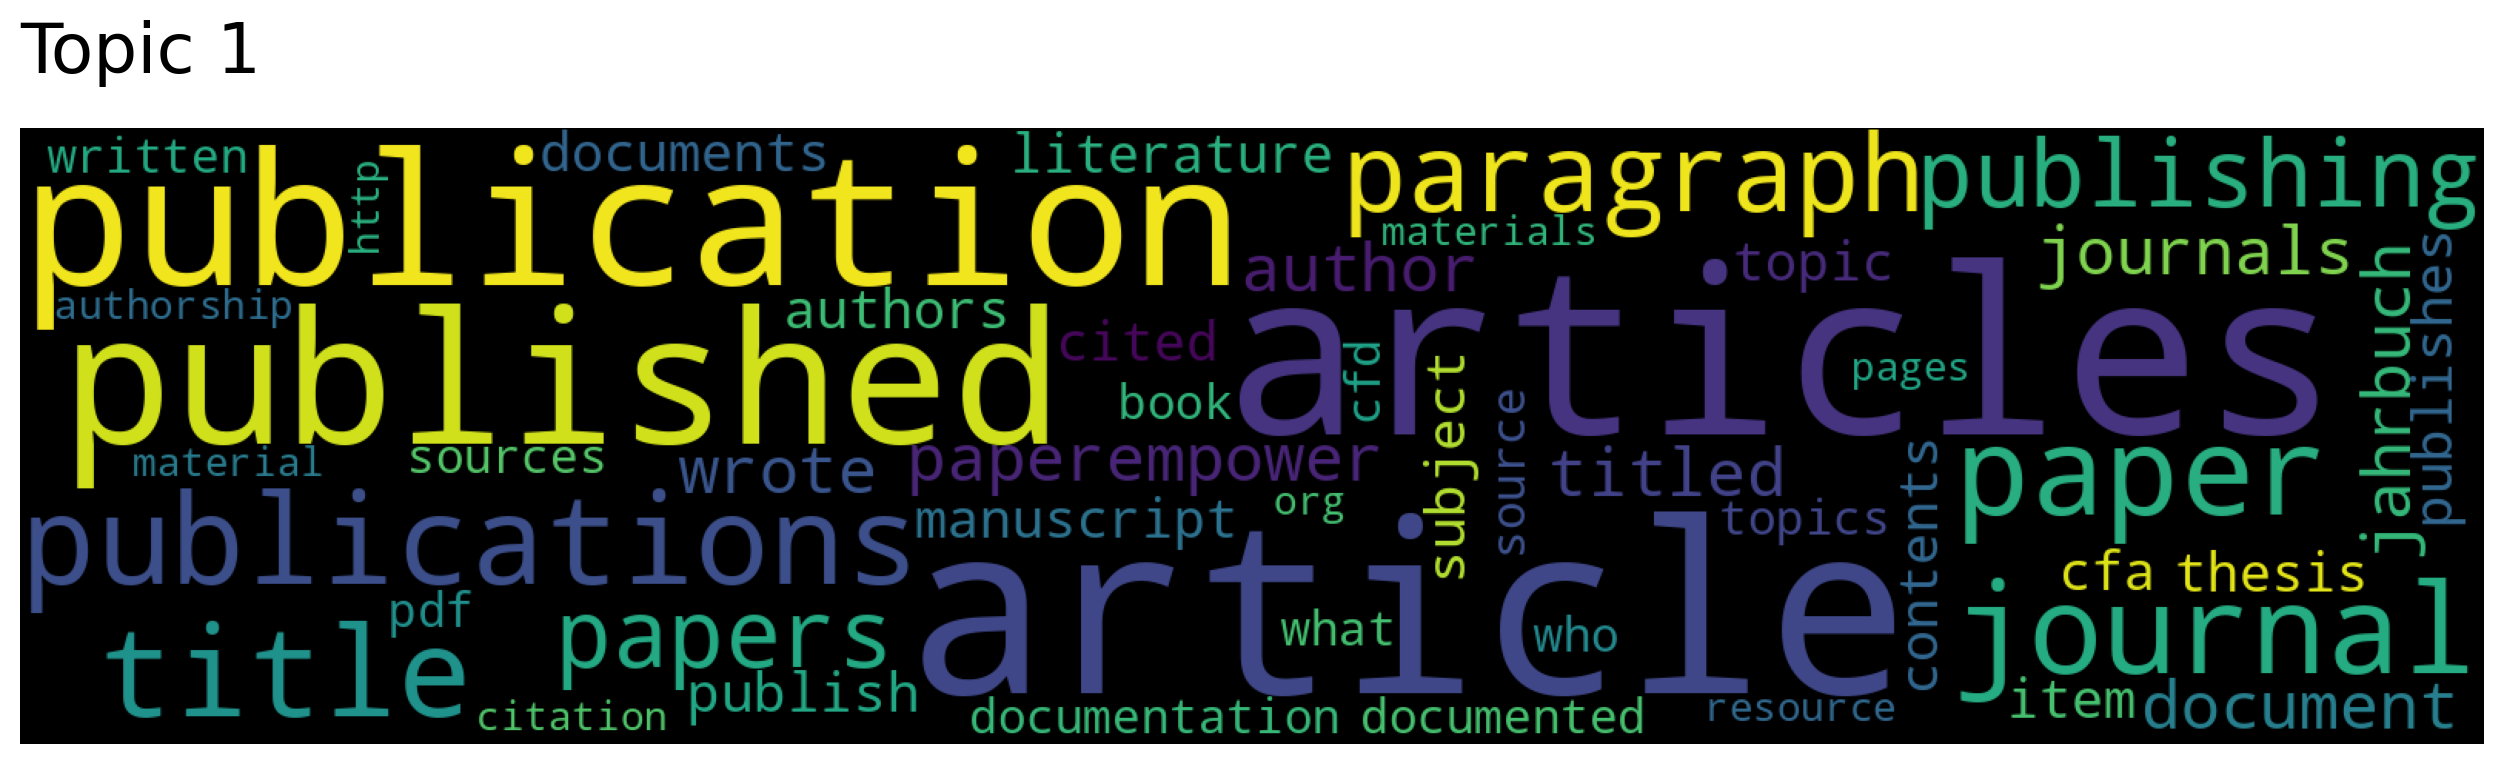

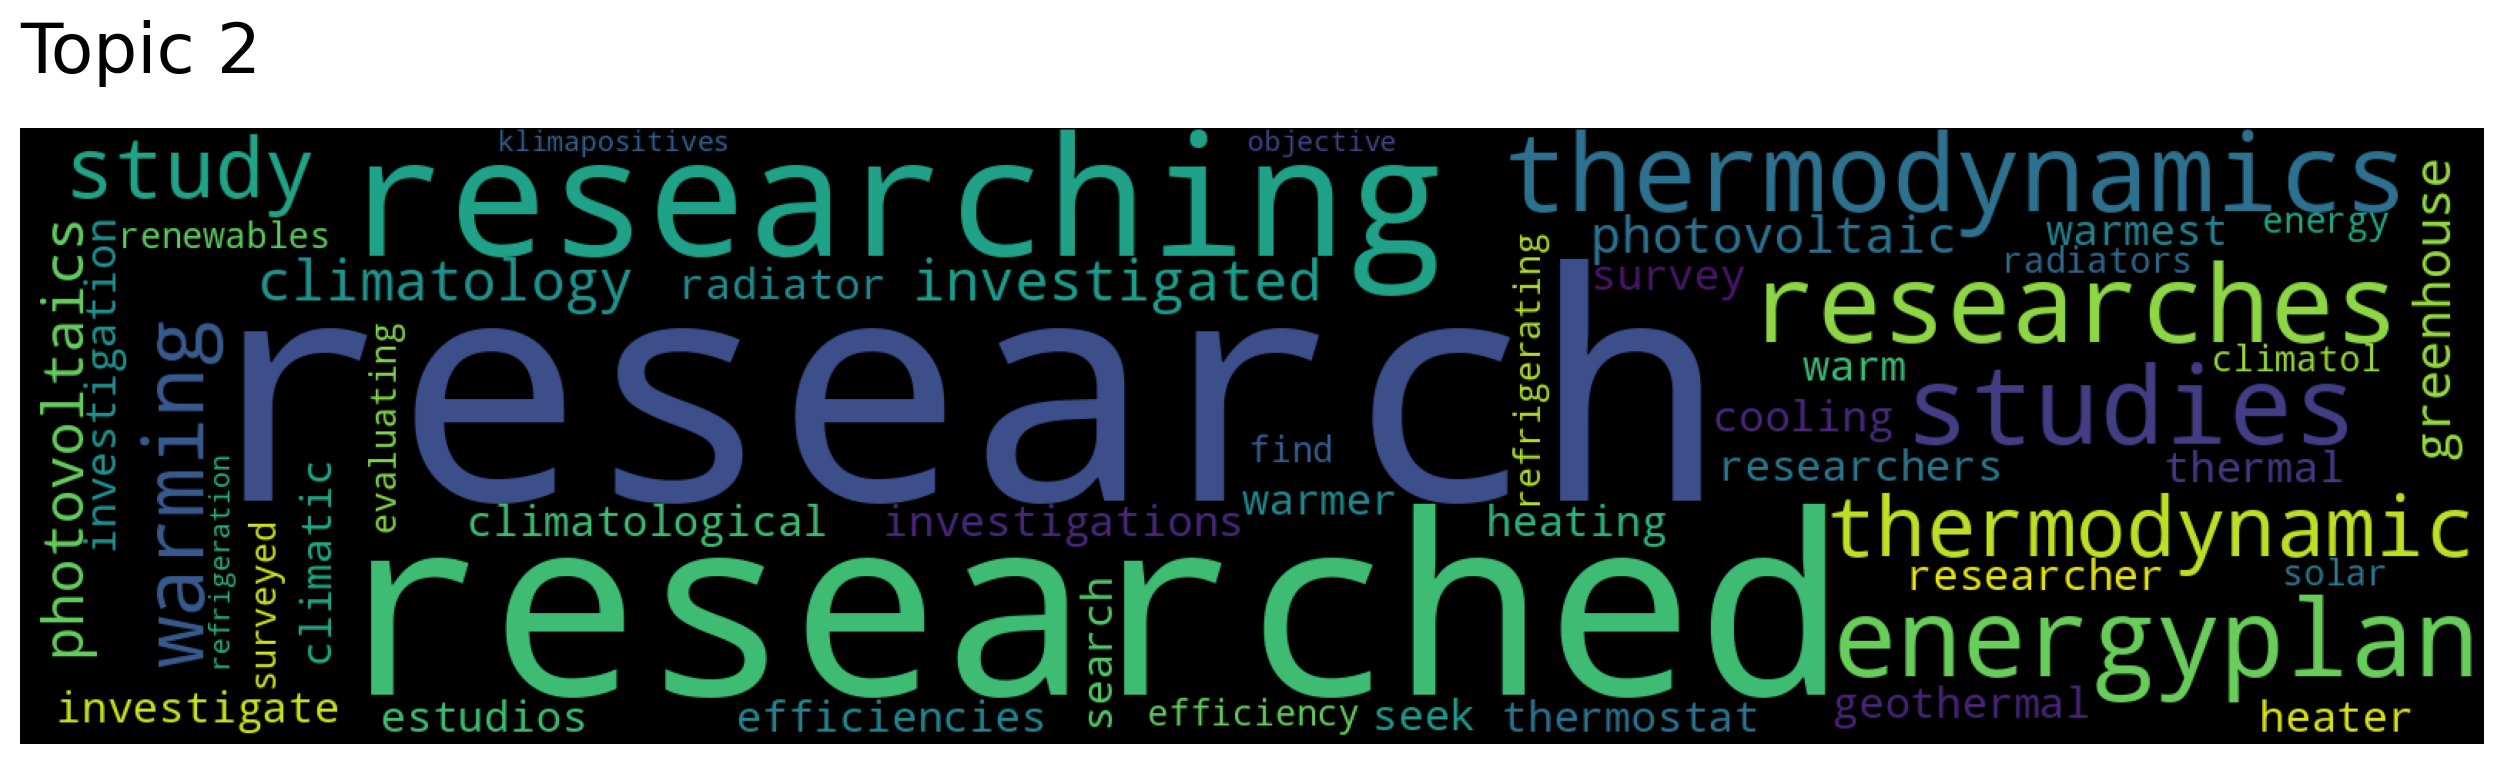

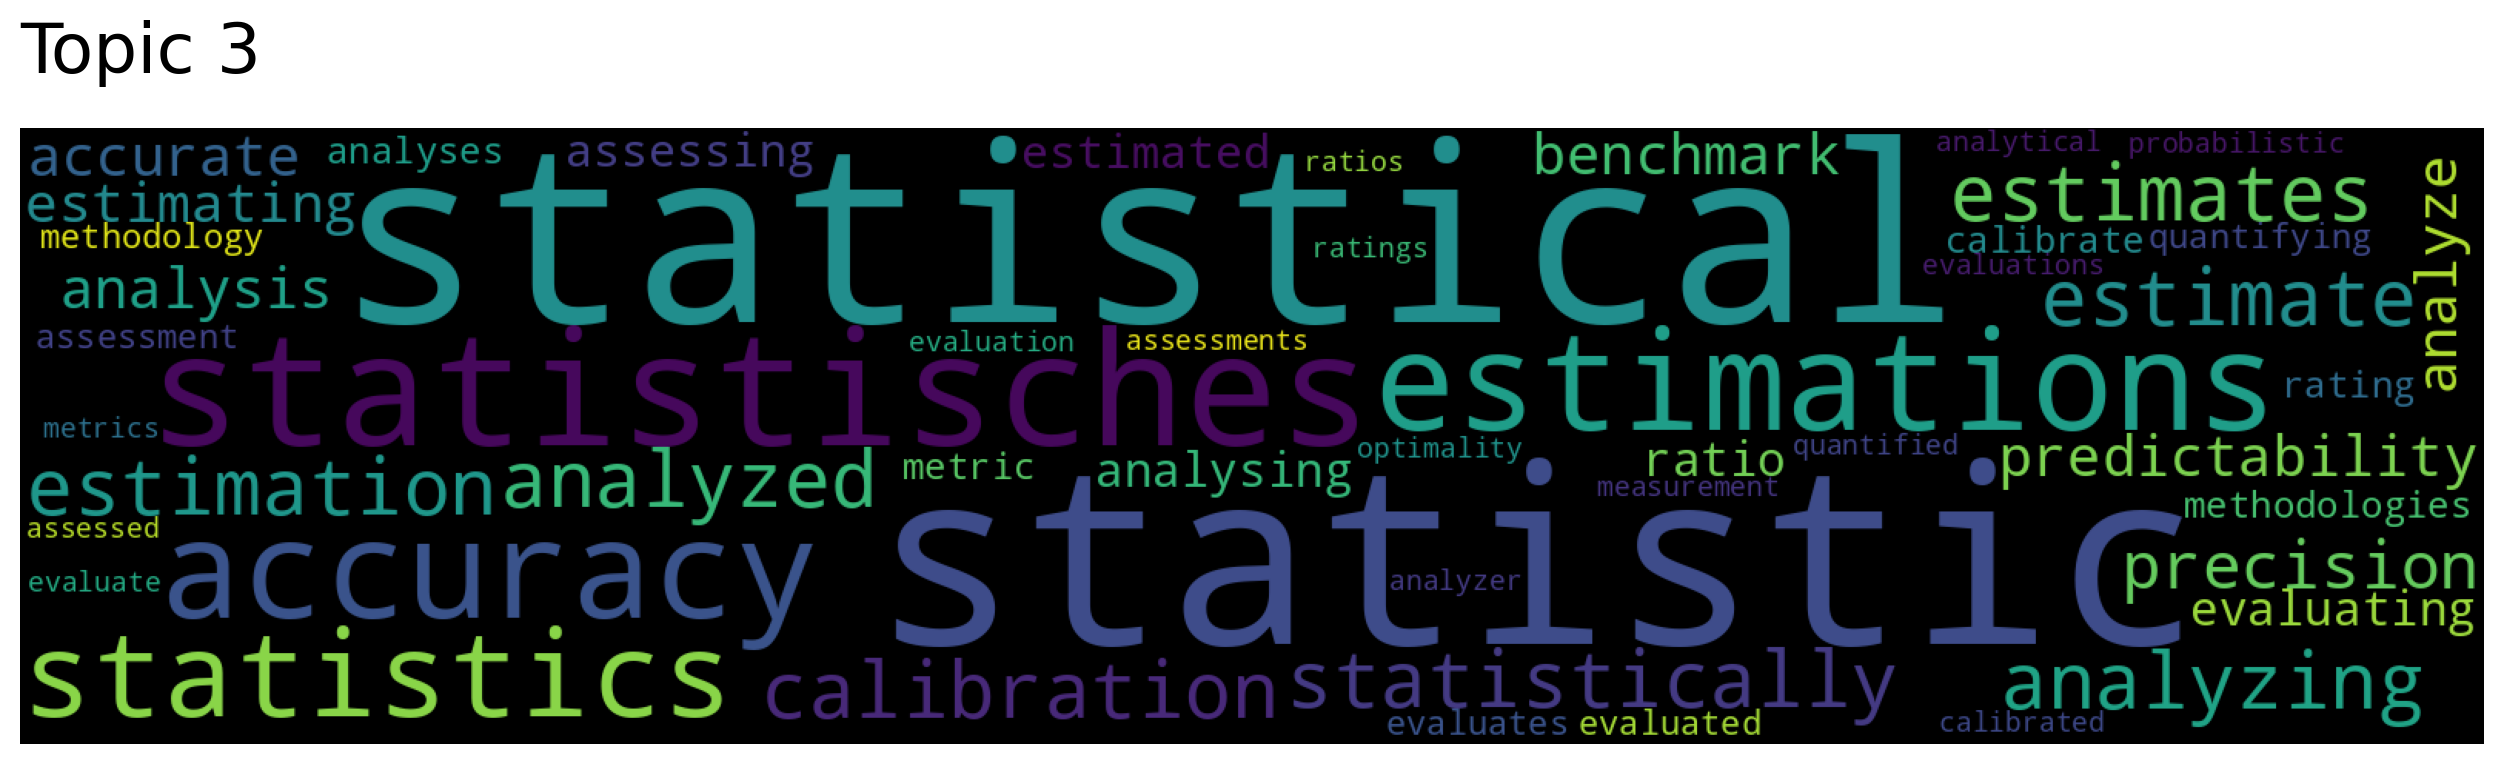

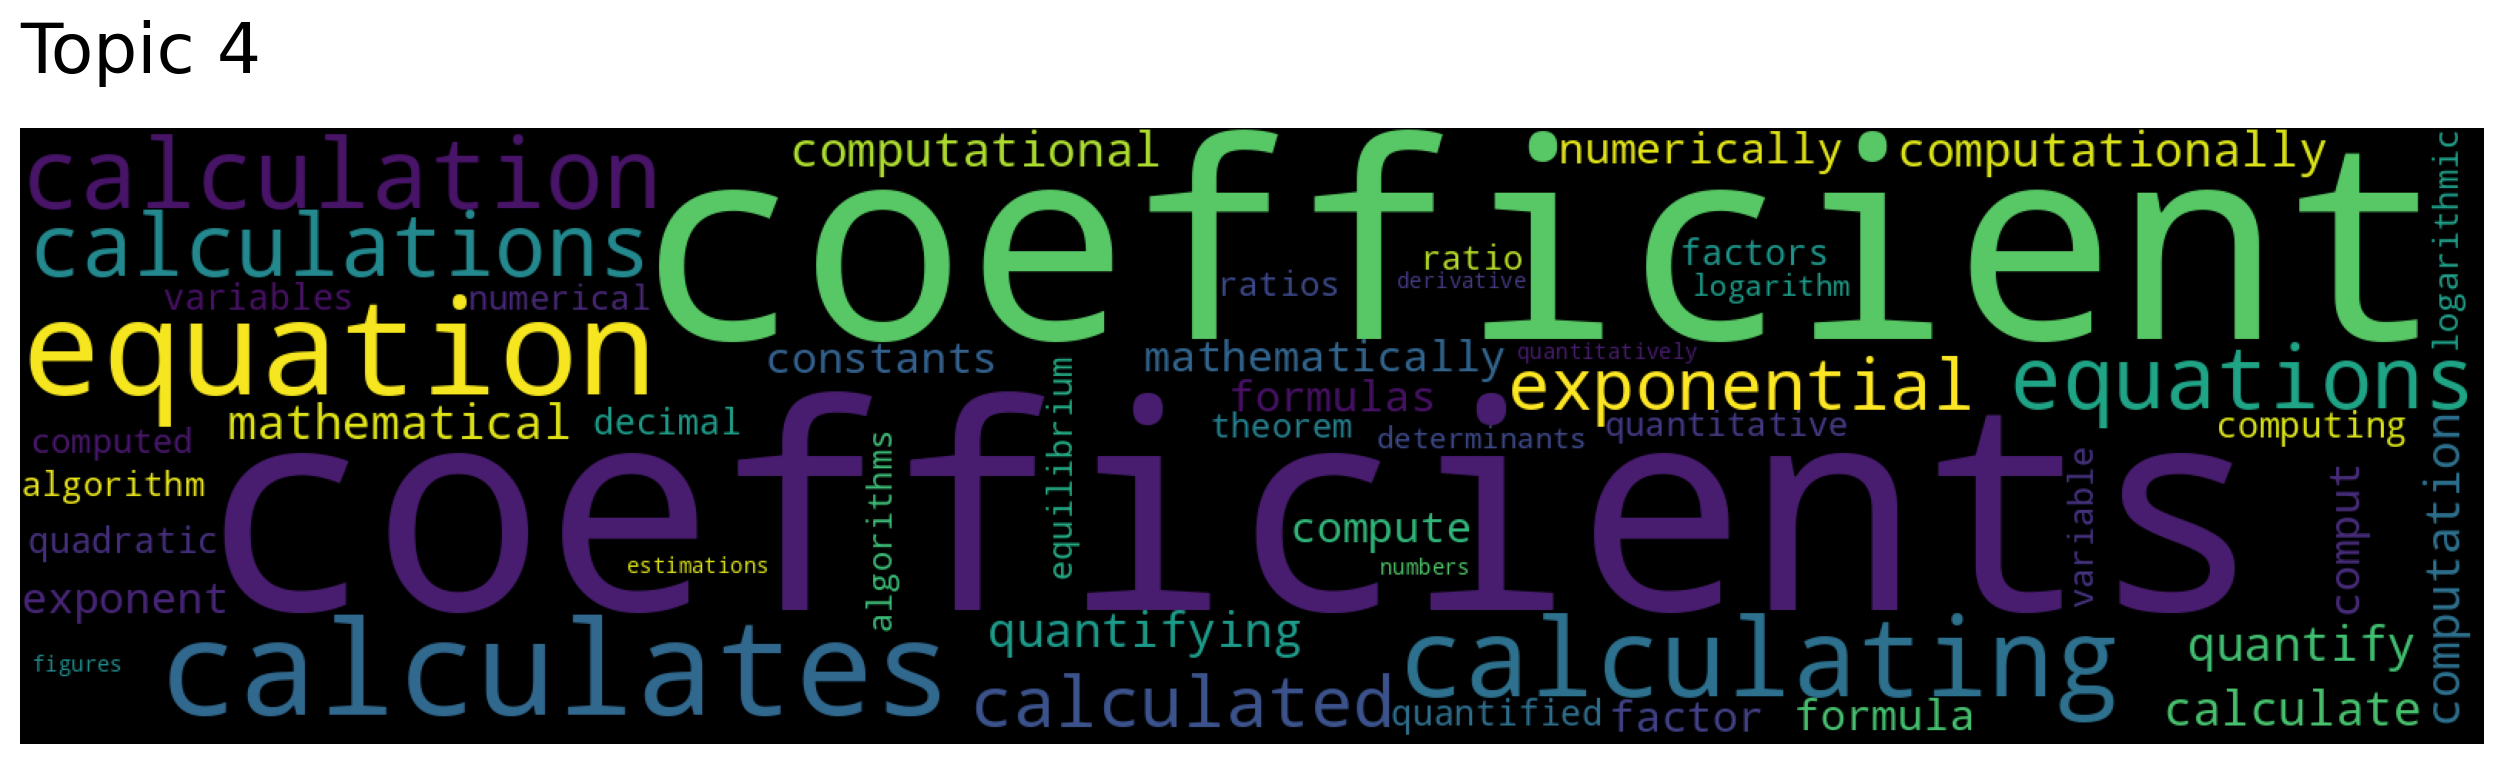

In [26]:
# for i in range( m.get_num_topics() ):
for i in range( min( m.get_num_topics(), 5 ) ):
    m.generate_topic_wordcloud( i )